In [1]:
import os
import re
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_info(path):
    # path: run path
    name = os.path.split(path)[1]

    with open(os.path.join(path, f'{name}_tag_1_banner.txt')) as f:
        for line in f.readlines():
                
            #  Integrated weight (pb)  :       0.020257
            match = re.match('#  Integrated weight \(pb\)  : +(\d+\.\d+)', line)
            if match:
                # unit: fb
                cross_section = float(match.group(1)) * 1000
            # #  Number of Events        :       100000
            match = re.match('#  Number of Events        :       (\d+)', line)
            if match:
                # unit: fb
                nevent = int(match.group(1))
    
    return cross_section, nevent

In [3]:
def DeltaR(eta1, phi1, eta2, phi2):
    dEta = eta1 - eta2
    dPhi = np.abs(phi1 - phi2)
    dPhi = np.where(dPhi > np.pi, 2 * np.pi - dPhi, dPhi)
    return np.sqrt(dEta ** 2 + dPhi ** 2)

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return e, px, py, pz

def PtEtaPhiM(px, py, pz, e):
    E, px, py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(E**2 - px**2 - py**2 - pz**2)

    return pt, eta, phi, m
    
def InvM(e, px, py, pz):
    return np.sqrt(np.sum(e)**2 - np.sum(px)**2 - np.sum(py)**2 - np.sum(pz)**2)

def Mjets(*arg):
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

In [4]:
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest    

In [5]:
def min_dR_pairing(PT, Eta, Phi, Mass):
    # 假設 PT, Eta, Phi, Mass 的形狀為 (n_events, 4)
    
    # 生成所有可能的配對 (n_pairs, 4)
    pairs = np.array(list(all_pairs([0, 1, 2, 3]))).reshape(-1, 4)

    # PT shape: (n_events, 4) -> (n_events, 1, 4), pairs shape: (n_pairs, 4) -> (1, n_pairs, 4)
    # output array shape: (n_events, n_pairs, 4)
    PT_pairs = np.take_along_axis(PT[:, None, :], pairs[None, :, :], axis=2)
    Eta_pairs = np.take_along_axis(Eta[:, None, :], pairs[None, :, :], axis=2)
    Phi_pairs = np.take_along_axis(Phi[:, None, :], pairs[None, :, :], axis=2)
    Mass_pairs = np.take_along_axis(Mass[:, None, :], pairs[None, :, :], axis=2)

    # e1 shape: (n_events, n_pairs, 2)
    # PTH1 shape: (n_events, n_pairs)
    e1, px1, py1, pz1 = FourMomentum(PT_pairs[..., :2], Eta_pairs[..., :2], Phi_pairs[..., :2], Mass_pairs[..., :2])
    PTH1, _, _, _ = PtEtaPhiM(np.sum(px1, axis=2), np.sum(py1, axis=2), np.sum(pz1, axis=2), np.sum(e1, axis=2))

    e2, px2, py2, pz2 = FourMomentum(PT_pairs[..., 2:], Eta_pairs[..., 2:], Phi_pairs[..., 2:], Mass_pairs[..., 2:])
    PTH2, _, _, _ = PtEtaPhiM(np.sum(px2, axis=2), np.sum(py2, axis=2), np.sum(pz2, axis=2), np.sum(e2, axis=2))
    
    # possible_pairs shape: (2, n_pairs, 4) -> (1, 2, n_pairs, 4)
    # greater_PT shape: (n_events, n_pairs) -> (n_events, 1, n_pairs, 1)  
    # indices shape: (n_events, 1, n_pairs, 4) -> (n_events, n_pairs, 4)
    possible_pairs = np.array([pairs, pairs[:,[2,3,0,1]]])
    greater_PT = np.where(PTH1 > PTH2, 0, 1)
    indices = np.take_along_axis(possible_pairs[None, ...] , greater_PT[:,None, :, None] , axis=1)[:,0,:,:]

    # Eta1, Phi1 shape: (n_events, n_pairs, 2)
    Eta1 = np.take_along_axis(Eta[:, None, :], indices[:,:,[0,1]], axis=2)
    Phi1 = np.take_along_axis(Phi[:, None, :], indices[:,:,[0,1]], axis=2)

    # dR shape: (n_events, n_pairs)
    dR = DeltaR(Eta1[:,:,0], Phi1[:,:,0], Eta1[:,:,1], Phi1[:,:,1])

    # 找到每個事件的最小 dR (n_events,)
    min_dR_indices = np.argmin(dR, axis=1)

    # output array shape: (n_events, 1, 4)
    # 返回最小 dR 的配對 (n_events, 4)
    return np.take_along_axis(indices, min_dR_indices[:, None, None], axis=1)[:,0,:]

In [6]:
def diHiggs_selection(file_path, tot_event, pairing_method, xection=None, SRSB_region=[[800, 1050], [700, 1100]], pt_cut=40):
    # file_path: h5 file path
    # tot_event: total event number
    
    cross_section = xection

    # signal and sideband range
    SR_range = SRSB_region[0]
    SB_range = SRSB_region[1]

    with h5py.File(file_path, 'r') as f:
        nevent = f['INPUTS/Source/pt'].shape[0]
        
        jet_PT = f['INPUTS/Source/pt'][...]
        jet_Eta = f['INPUTS/Source/eta'][...]
        jet_Phi = f['INPUTS/Source/phi'][...]
        jet_Mass = f['INPUTS/Source/mass'][...]
        jet_BTag = f['INPUTS/Source/btag'][...]

    # |eta| < 2.5 & PT > 40 GeV & b-tagged
    eta_pt_bTag_cut = ((np.abs(jet_Eta) < 2.5) & (jet_PT > pt_cut) & (jet_BTag == 1))

    if pairing_method == 'min_dR':
        # choose 4 highest pt b-jets
        nbj = np.sum(eta_pt_bTag_cut, axis=1)
        eta_pt_bTag_cut = eta_pt_bTag_cut[nbj >= 4]

        jet_PT = jet_PT[nbj >= 4]
        jet_Eta = jet_Eta[nbj >= 4]
        jet_Phi = jet_Phi[nbj >= 4]
        jet_Mass = jet_Mass[nbj >= 4]

        h_jets = np.array([np.where(row)[0][:4] for row in eta_pt_bTag_cut])

        PT = np.take_along_axis(jet_PT, h_jets, axis=1)
        Eta = np.take_along_axis(jet_Eta, h_jets, axis=1)
        Phi = np.take_along_axis(jet_Phi, h_jets, axis=1)
        Mass = np.take_along_axis(jet_Mass, h_jets, axis=1)
        h_candidate = min_dR_pairing(PT, Eta, Phi, Mass)
    else:
        print('Wrong pairing method!')
        return

    # Total invariant mass: mhh
    e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
    _, _, _, m4j = PtEtaPhiM(np.sum(px, axis=1), np.sum(py, axis=1), np.sum(pz, axis=1), np.sum(e, axis=1))

    # Get Higgs candidates information
    i1i2, i3i4 = h_candidate[:,[0,1]], h_candidate[:,[2,3]]

    PT1 = np.take_along_axis(PT, i1i2, axis=1)
    Eta1 = np.take_along_axis(Eta, i1i2, axis=1)
    Phi1 = np.take_along_axis(Phi, i1i2, axis=1)
    Mass1 = np.take_along_axis(Mass, i1i2, axis=1)

    e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
    _, _, _, MassH1 = PtEtaPhiM(np.sum(px1, axis=1), np.sum(py1, axis=1), np.sum(pz1, axis=1), np.sum(e1, axis=1))

    PT2 = np.take_along_axis(PT, i3i4, axis=1)
    Eta2 = np.take_along_axis(Eta, i3i4, axis=1)
    Phi2 = np.take_along_axis(Phi, i3i4, axis=1)
    Mass2 = np.take_along_axis(Mass, i3i4, axis=1)

    e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
    _, _, _, MassH2 = PtEtaPhiM(np.sum(px2, axis=1), np.sum(py2, axis=1), np.sum(pz2, axis=1), np.sum(e2, axis=1))
            
    SR_count = ((SR_range[0] < m4j) & (m4j < SR_range[1])).sum()
    SB_count = (((SB_range[0] < m4j) & (m4j < SR_range[0])) | ((SR_range[1] < m4j) & (m4j < SB_range[1]))).sum()

    # 經過 |eta| < 2.5, PT > pt_cut for 4 b-jets 的截面
    cross_section_abs = cross_section * nevent / tot_event

    cutflow_count = {
        'nevent': tot_event,
        'Cross section': cross_section,
        'Four tag': nevent,
        'Signal region': SR_count,
        'Sideband region': SB_count,
    }
        
    cutflow_cross_section = {
        'nevent': nevent,
        'Cross section': cross_section,
        'Four tag': cross_section_abs,
        'Signal region': cross_section_abs * SR_count / nevent,
        'Sideband region': cross_section_abs * SB_count / nevent,
    }

    results = {
        'cutflow count': cutflow_count,
        'cutflow cross section':cutflow_cross_section,
        'mh': np.array([MassH1, MassH2]),
        'mhh': m4j,
    }

    return results

In [7]:
SRSB_region = [[800, 1050], [700, 1100]]
# Background
run_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/MG5/resonant/pp4b_2525/Events/run_01'
h5_path = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Sample/h5_data/resonant/pp4b_2525/1M_diHiggs_4b_PT40-01.h5'

xection, tot_event = get_info(run_path)
pairing_method = 'min_dR'

results_40 = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              SRSB_region,
                              pt_cut=40,
                              )

results_50 = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              SRSB_region,
                              pt_cut=50,
                              )

results_60 = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              SRSB_region,
                              pt_cut=60,
                              )

results_70 = diHiggs_selection(h5_path,
                              tot_event, 
                              pairing_method, 
                              xection,
                              SRSB_region,
                              pt_cut=70,
                              )

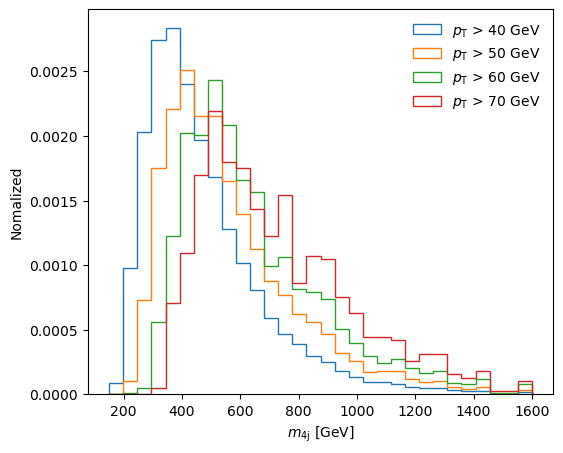

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6, 5))

ax.hist(results_40['mhh'], range=(150,1600), bins=30, histtype='step', density=True, label='$p_\mathrm{T}$ > 40 GeV')
ax.hist(results_50['mhh'], range=(150,1600), bins=30, histtype='step', density=True, label='$p_\mathrm{T}$ > 50 GeV')
ax.hist(results_60['mhh'], range=(150,1600), bins=30, histtype='step', density=True, label='$p_\mathrm{T}$ > 60 GeV')
ax.hist(results_70['mhh'], range=(150,1600), bins=30, histtype='step', density=True, label='$p_\mathrm{T}$ > 70 GeV')

ax.set_xlabel('$m_\mathrm{4j}$ [GeV]')
ax.set_ylabel('Nomalized')

ax.legend(frameon=False)
plt.savefig('./figures/m4j_distribution_background_various_pt_cut.png', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()